# Metrics Analysis

분자 이름, 방법 이름, 시뮬레이션 k 값이 주어지면 rmsds.npy, etss.npy를 불러와서 rmsd mean, std, thp, ets mean, std를 측정하는 노트북


In [ ]:
import numpy as np
import os
from pathlib import Path
import json

# Configuration from run_experiments.py
# MOLECULES = ["chignolin", "trpcage", "chignolin_implicit", "trpcage_implicit"]
MOLECULES = ["chignolin"]  # For testing
# METHODS = ["ours", "rmsd", "tae", "vde", "deeptda", "deeptica"]
METHODS = ["ours", "rmsd", "tae"]
K_VALUES = [100, 200, 500, 1000, 2000, 5000, 10000, 20000]

# Molecule-specific thresholds (in angstrom)
MOLECULE_THRESHOLDS = {
    "chignolin": 10.0,
    "trpcage": 10.0,
    "chignolin_implicit": 10.0,
    "trpcage_implicit": 10.0
}


In [2]:
def calculate_metrics(rmsds, etss, threshold):
    """
    Calculate metrics from rmsds and etss numpy arrays
    
    Args:
        rmsds: numpy array of RMSD values (in angstrom)
        etss: numpy array of ETS values
        threshold: threshold for hit calculation (angstrom)
    
    Returns:
        dict: metrics containing rmsd, rmsd_std, thp, ets, ets_std
    """
    metrics = {}
    
    # Calculate hit based on threshold
    hit = rmsds < threshold
    thp = 100 * hit.sum() / len(hit)  # Target hit percentage
    
    # Calculate RMSD metrics
    metrics["rmsd"] = rmsds.mean()
    metrics["rmsd_std"] = rmsds.std()
    
    # Calculate THP
    metrics["thp"] = thp
    
    # Calculate ETS metrics (only for hits)
    if hit.sum() > 0:
        etss_hit = etss[hit]
        metrics["ets"] = etss_hit.mean()
        metrics["ets_std"] = etss_hit.std()
    else:
        metrics["ets"] = np.nan
        metrics["ets_std"] = np.nan
    
    return metrics


In [3]:
def load_and_analyze(molecule_name, method_name, k_value, threshold, base_dir="res"):
    """
    Load rmsds.npy and etss.npy files and calculate metrics
    
    Args:
        molecule_name: name of the molecule (e.g., 'chignolin')
        method_name: name of the method (e.g., 'vde')
        k_value: simulation k value (e.g., 10000)
        threshold: threshold for hit calculation (angstrom). If None, uses molecule-specific threshold
        base_dir: base directory for data files
    
    Returns:
        dict: calculated metrics
    """
    
    # Construct file paths
    data_dir = Path(base_dir) / molecule_name / method_name / str(k_value)
    rmsds_path = data_dir / "rmsds.npy"
    etss_path = data_dir / "etss.npy"
    
    # Check if files exist
    if not rmsds_path.exists():
        raise FileNotFoundError(f"RMSD file not found: {rmsds_path}")
    if not etss_path.exists():
        raise FileNotFoundError(f"ETS file not found: {etss_path}")
    
    # Load data
    print(f"Loading data from: {data_dir} (threshold: {threshold:.1f} Å)")
    rmsds = np.load(rmsds_path)
    etss = np.load(etss_path)
    
    print(f"RMSD shape: {rmsds.shape}, ETS shape: {etss.shape}")
    print(f"RMSD range: {rmsds.min():.4f} - {rmsds.max():.4f} Å")
    print(f"ETS range: {etss.min():.4f} - {etss.max():.4f}")
    
    # Calculate metrics
    metrics = calculate_metrics(rmsds, etss, threshold)
    
    return metrics


## Comprehensive Analysis

모든 분자, 메소드, k 값에 대해 metrics를 계산하고 LaTeX 테이블을 생성


In [4]:
def collect_all_metrics(base_dir="res"):
    """
    Collect metrics for all experiments using numpy arrays with molecule-specific thresholds
    
    Args:
        base_dir: base directory for data files
    
    Returns:
        dict: all_metrics with keys as (molecule, method, k) tuples
    """
    all_metrics = {}
    
    for molecule in MOLECULES:
        threshold = MOLECULE_THRESHOLDS.get(molecule)
        print(f"\nProcessing {molecule} (threshold: {threshold:.1f} Å)...")
        
        for method in METHODS:
            print(f"\nProcessing {molecule}/{method}...")
            
            for k in K_VALUES:
                try:
                    # Pass None for threshold to use molecule-specific threshold
                    metrics = load_and_analyze(molecule, method, k, threshold, base_dir=base_dir)
                    all_metrics[(molecule, method, k)] = metrics
                    print(f"✓ Calculated metrics for {molecule}/{method}/{k}")
                except FileNotFoundError:
                    print(f"✗ Missing data for {molecule}/{method}/{k}")
                    all_metrics[(molecule, method, k)] = None
                except Exception as e:
                    print(f"✗ Error in {molecule}/{method}/{k}: {e}")
                    all_metrics[(molecule, method, k)] = None
    return all_metrics


In [5]:
def generate_method_table_lines(molecule, method, all_metrics):
    """Generate LaTeX table lines for a specific molecule/method combination with K values as rows."""
    latex_lines = [
        "\\begin{table}[h]", "\\centering", 
        f"\\caption{{Results for {molecule.capitalize()} using {method.upper()}}}",
        "\\begin{tabular}{l|c|c|c}", "\\hline",
        "K & RMSD ($\\pm$ std) & THP (\\%) & ETS ($\\pm$ std) \\\\", "\\hline"
    ]
    
    for k in K_VALUES:
        metrics = all_metrics.get((molecule, method, k))
        if metrics:
            rmsd = f"{metrics['rmsd']:.2f}" + (f" $\\pm$ {metrics['rmsd_std']:.2f}" if 'rmsd_std' in metrics else "")
            thp = f"{metrics.get('thp', 0):.1f}"
            ets = f"{metrics['ets']:.2f}" + (f" $\\pm$ {metrics['ets_std']:.2f}" if 'ets_std' in metrics else "") if 'ets' in metrics and not np.isnan(metrics['ets']) else "N/A"
            latex_lines.append(f"{k} & {rmsd} & {thp} & {ets} \\\\")
        else:
            latex_lines.append(f"{k} & N/A & N/A & N/A \\\\")
    
    latex_lines.extend(["\\hline", "\\end{tabular}", f"\\label{{tab:{molecule}_{method}_results}}", "\\end{table}"])
    
    return latex_lines


In [6]:
def generate_all_tables(all_metrics, output_dir="tables"):
    """Generate all LaTeX tables in a single file with K values as rows."""
    os.makedirs(output_dir, exist_ok=True)
    
    all_latex_lines = []
    
    for molecule in MOLECULES:
        all_latex_lines.append(f"\n% Results for {molecule.capitalize()}")
        for method in METHODS:
            table_lines = generate_method_table_lines(molecule, method, all_metrics)
            all_latex_lines.extend(table_lines)
            all_latex_lines.append("")  # Empty line between tables
    
    # Write all tables to a single file
    output_file = os.path.join(output_dir, "all_results.tex")
    with open(output_file, 'w') as f:
        f.write('\n'.join(all_latex_lines))
    print(f"All LaTeX tables saved to: {output_file}")
    print(f"Generated {len(MOLECULES) * len(METHODS)} tables in single file")

In [7]:
def save_all_metrics_json(all_metrics, output_file="res/all_metrics.json"):
    """Save all metrics to JSON file with proper formatting"""
    # Convert metrics to serializable format
    json_metrics = {}
    for (molecule, method, k), metrics in all_metrics.items():
        key = f"{molecule}_{method}_{k}"
        if metrics is not None:
            # Convert numpy types to Python types
            json_metrics[key] = {
                k: float(v) if not np.isnan(v) else None for k, v in metrics.items()
            }
        else:
            json_metrics[key] = None
    
    with open(output_file, 'w') as f:
        json.dump(json_metrics, f, indent=2)
    
    print(f"All metrics saved to: {output_file}")


## Run Comprehensive Analysis

모든 실험에 대해 metrics를 계산하고 LaTeX 테이블을 생성합니다.


In [8]:
# 모든 실험에 대해 metrics 수집
print("Starting comprehensive metrics analysis with molecule-specific thresholds...")
print(f"Processing {len(MOLECULES)} molecules × {len(METHODS)} methods × {len(K_VALUES)} K values = {len(MOLECULES) * len(METHODS) * len(K_VALUES)} experiments")
print(f"Molecule-specific thresholds: {MOLECULE_THRESHOLDS}")

# Collect all metrics using molecule-specific thresholds
all_metrics = collect_all_metrics()

# Count successful experiments
successful = sum(1 for v in all_metrics.values() if v is not None)
total = len(all_metrics)
print(f"\nCollected metrics for {successful}/{total} experiments")

# Save metrics to JSON
save_all_metrics_json(all_metrics)

# Generate LaTeX tables
generate_all_tables(all_metrics)


Starting comprehensive metrics analysis with molecule-specific thresholds...
Processing 1 molecules × 3 methods × 8 K values = 24 experiments
Molecule-specific thresholds: {'chignolin': 10.0, 'trpcage': 5.0, 'chignolin_implicit': 5.0, 'trpcage_implicit': 5.0}

Processing chignolin (threshold: 10.0 Å)...

Processing chignolin/ours...
Loading data from: res/chignolin/ours/100 (threshold: 10.0 Å)
RMSD shape: (2,), ETS shape: (2,)
RMSD range: 9.4549 - 9.7365 Å
ETS range: -82119.7031 - -82077.6250
✓ Calculated metrics for chignolin/ours/100
Loading data from: res/chignolin/ours/200 (threshold: 10.0 Å)
RMSD shape: (2,), ETS shape: (2,)
RMSD range: 9.4638 - 9.6320 Å
ETS range: -82047.2266 - -81892.9297
✓ Calculated metrics for chignolin/ours/200
Loading data from: res/chignolin/ours/500 (threshold: 10.0 Å)
RMSD shape: (2,), ETS shape: (2,)
RMSD range: 8.7890 - 9.1766 Å
ETS range: -82136.4453 - -82022.7812
✓ Calculated metrics for chignolin/ours/500
Loading data from: res/chignolin/ours/1000 (

## Summary Statistics

전체 결과에 대한 요약 통계


In [9]:
# 실험별 성공률 분석
print("=== Experiment Success Rate Analysis ===")

# By molecule
print("\nBy Molecule:")
for molecule in MOLECULES:
    mol_total = len(METHODS) * len(K_VALUES)
    mol_success = sum(1 for (m, method, k), v in all_metrics.items() if m == molecule and v is not None)
    print(f"{molecule}: {mol_success}/{mol_total} ({mol_success/mol_total*100:.1f}%)")

# By method
print("\nBy Method:")
for method in METHODS:
    method_total = len(MOLECULES) * len(K_VALUES)
    method_success = sum(1 for (molecule, m, k), v in all_metrics.items() if m == method and v is not None)
    print(f"{method}: {method_success}/{method_total} ({method_success/method_total*100:.1f}%)")

# By K value
print("\nBy K Value:")
for k in K_VALUES:
    k_total = len(MOLECULES) * len(METHODS)
    k_success = sum(1 for (molecule, method, kk), v in all_metrics.items() if kk == k and v is not None)
    print(f"K={k}: {k_success}/{k_total} ({k_success/k_total*100:.1f}%)")


=== Experiment Success Rate Analysis ===

By Molecule:
chignolin: 17/24 (70.8%)

By Method:
ours: 4/8 (50.0%)
rmsd: 8/8 (100.0%)
tae: 5/8 (62.5%)

By K Value:
K=100: 3/3 (100.0%)
K=200: 3/3 (100.0%)
K=500: 3/3 (100.0%)
K=1000: 2/3 (66.7%)
K=2000: 3/3 (100.0%)
K=5000: 1/3 (33.3%)
K=10000: 1/3 (33.3%)
K=20000: 1/3 (33.3%)


## RMSD vs ETS Trade-off Visualization

`run_experiments.py`와 `analysis.ipynb`를 참고하여 RMSD와 ETS의 trade-off를 시각화합니다.


In [10]:
import matplotlib.pyplot as plt

def plot_rmsd_ets_tradeoff(all_metrics, output_dir="figures"):
    """
    Plot RMSD vs ETS trade-off for all methods and K values.
    Creates separate figures for each molecule.
    
    Args:
        all_metrics: Dictionary with metrics data
        output_dir: Directory to save the plots
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Color and marker settings for each method (matching run_experiments.py)
    method_styles = {
        "ours": {"color": "red", "marker": "o", "label": "Ours"},
        "rmsd": {"color": "blue", "marker": "s", "label": "RMSD"},
        "tae": {"color": "green", "marker": "^", "label": "TAE"},
        "vde": {"color": "orange", "marker": "v", "label": "VDE"},
        "deeptda": {"color": "purple", "marker": "d", "label": "DeepTDA"},
        "deeptica": {"color": "brown", "marker": "p", "label": "DeepTICA"}
    }
    
    # Create plots for each molecule
    saved_files = []
    
    for molecule in MOLECULES:
        plt.figure(figsize=(8, 6))
        
        # Plot data for each method
        methods_with_data = []
        
        for method in METHODS:
            rmsd_values = []
            ets_values = []
            k_labels = []
            
            # Extract RMSD and ETS values for each K
            for k in K_VALUES:
                metrics = all_metrics.get((molecule, method, k))
                if metrics and 'rmsd' in metrics and 'ets' in metrics and not np.isnan(metrics['ets']):
                    rmsd_values.append(metrics['rmsd'])
                    ets_values.append(metrics['ets'])
                    k_labels.append(k)
            
            # Plot if we have data
            if rmsd_values and ets_values:
                methods_with_data.append(method)
                style = method_styles[method]
                plt.plot(rmsd_values, ets_values, 
                           color=style["color"], 
                           marker=style["marker"], 
                           linewidth=2, 
                           markersize=8,
                           alpha=0.8,
                           label=style["label"])
                
                # Add K value annotations for some points
                # for i, (rmsd, ets, k) in enumerate(zip(rmsd_values, ets_values, k_labels)):
                #     if i % 2 == 0:  # Annotate every other point to avoid crowding
                #         plt.annotate(f'{k//1000}k', 
                #                    (rmsd, ets), 
                #                    xytext=(5, 5), 
                #                    textcoords='offset points', 
                #                    fontsize=9, 
                #                    alpha=0.7)
        
        # Customize the plot
        plt.xlabel('RMSD (Å)', fontsize=14, fontweight='bold')
        plt.ylabel('ETS', fontsize=14, fontweight='bold')
        plt.title(f'RMSD vs ETS Trade-off: {molecule.capitalize().replace("_", " ")}', 
                 fontsize=14, fontweight='bold')
        
        if methods_with_data:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
            print(f"Methods with data for {molecule}: {', '.join(methods_with_data)}")
        else:
            print(f"No valid data found for {molecule}")
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save the figure
        output_file_png = os.path.join(output_dir, f'{molecule}_rmsd_ets_tradeoff.png')
        output_file_pdf = os.path.join(output_dir, f'{molecule}_rmsd_ets_tradeoff.pdf')
        
        plt.savefig(output_file_png, dpi=300, bbox_inches='tight')
        plt.savefig(output_file_pdf, bbox_inches='tight')
        
        saved_files.extend([output_file_png, output_file_pdf])
        
        print(f"Saved plots for {molecule}:")
        print(f"  PNG: {output_file_png}")
        print(f"  PDF: {output_file_pdf}")
        
        plt.show()
    
    return saved_files


Generating RMSD vs ETS trade-off plots...
Using metrics from 17 successful experiments
Methods with data for chignolin: ours, rmsd, tae
Saved plots for chignolin:
  PNG: figures/chignolin_rmsd_ets_tradeoff.png
  PDF: figures/chignolin_rmsd_ets_tradeoff.pdf


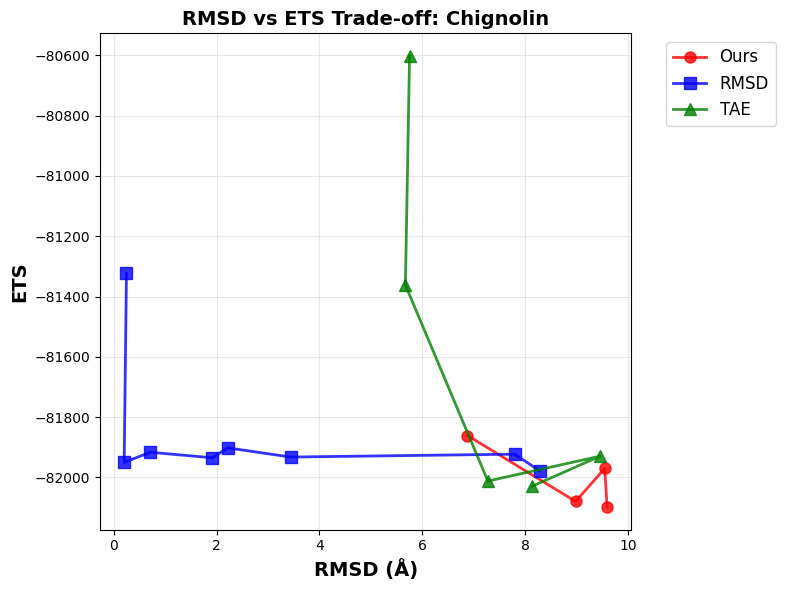


🎨 All RMSD vs ETS trade-off plots saved to: figures
Total files created: 2
Analysis with trade-off plots completed!


In [11]:
# Generate RMSD vs ETS trade-off plots using collected metrics
print("Generating RMSD vs ETS trade-off plots...")
print(f"Using metrics from {successful} successful experiments")

# Create plots
figures_dir = "figures"
plot_files = plot_rmsd_ets_tradeoff(all_metrics, figures_dir)

print(f"\n🎨 All RMSD vs ETS trade-off plots saved to: {figures_dir}")
print(f"Total files created: {len(plot_files)}")
print("Analysis with trade-off plots completed!")


In [12]:
# Test molecule-specific thresholds
print("Testing molecule-specific thresholds:")
for molecule in MOLECULES:
    threshold = MOLECULE_THRESHOLDS.get(molecule)
    print(f"  {molecule}: {threshold:.1f} Å")

# Test with a small subset
print(f"\nTotal experiments: {len(MOLECULES)} × {len(METHODS)} × {len(K_VALUES)} = {len(MOLECULES) * len(METHODS) * len(K_VALUES)}")
print(f"Methods: {METHODS}")
print(f"K values: {K_VALUES}")


Testing molecule-specific thresholds:
  chignolin: 10.0 Å

Total experiments: 1 × 3 × 8 = 24
Methods: ['ours', 'rmsd', 'tae']
K values: [100, 200, 500, 1000, 2000, 5000, 10000, 20000]
